In [1]:
import open3d as o3d
import numpy as np
from einops import rearrange

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

NameError: name 'pcd' is not defined

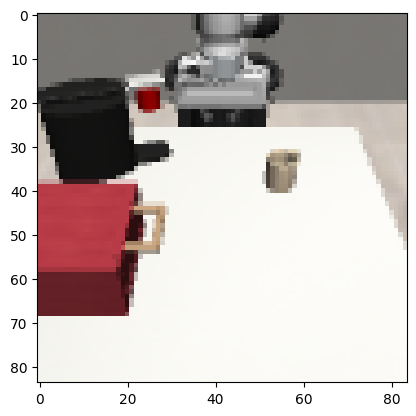

In [23]:
# robomimic dataset description https://robomimic.github.io/docs/datasets/overview.html
import h5py
from matplotlib import pyplot as plt

dataset_path = "/data/yuanhong/mimicgen_data/core_datasets/coffee_preparation/demo_src_coffee_preparation_all_pose_task_D1/demo.hdf5"

with h5py.File(dataset_path, 'r') as f:
    print(np.array(f["data/demo_0/action_subtask_labels/"]))
    print(next(iter(f["data/"])))

    depth = f["data/demo_0/obs/agentview_depth"]
    image = f["data/demo_0/obs/agentview_image"]
    traj = f["data/demo_0/datagen_info/object_poses/coffee_pod"]
    # flow = np.array(f["data/demo_0"]["3d_flow"])
    # pcd = np.array(f["data/demo_0"]["pcd"])
    # color = np.array(f["data/demo_0"]["pcd_rgb"])
    # mask = np.array(f["data/demo_0"]["mask"])
    machine = np.array(f["data/demo_0/datagen_info/object_poses/coffee_pod"])

    depth_np = np.array(depth)
    image_np = np.array(image)
    traj_np = np.array(traj)  # stores the position of the coffee pod in Homogeneous Transformation Matrices

plt.imshow(image_np[0])
traj_np[0][0:3,-1]
np.concatenate([pcd, color], axis=1).shape
np.sum(mask)

In [35]:
machine[2] - machine[3]

array([[ 3.41184792e-09,  2.40393222e-09, -5.77033635e-05,
        -6.32609876e-06],
       [-5.35455708e-09,  9.57114832e-10, -1.70783208e-05,
        -1.90984314e-06],
       [ 6.01328618e-05, -2.32079904e-06,  1.65127423e-09,
         1.64232255e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [3]:
# Grounded SAM https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Grounding%20DINO/GroundingDINO_with_Segment_Anything.ipynb
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))


def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def detect_pattern(
    image: Image.Image,
    pattern: Image.Image
) -> List[Dict[str, Any]]:
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    cv_pattern = cv2.cvtColor(np.array(pattern), cv2.COLOR_RGB2GRAY)

    result = cv2.matchTemplate(cv_image, cv_pattern, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = min_loc
    h, w = cv_pattern.shape

    xmin = top_left[0]
    ymin = top_left[1]
    xmax = top_left[0] + w
    ymax = top_left[1] + h

    return [DetectionResult.from_dict({"score":1, "label":"", "box":{"xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}})]
    

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = np.any(mask.cpu().numpy(), axis=0)

    return detection_results

def grounded_segmentation(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, segmenter_id)

    return detections

In [4]:
# detect with Grounded DINO + SAM
detections = grounded_segmentation(
    image=Image.fromarray(image_np[0]),
    labels=["a white coffee pod"],
    threshold=0.3
)

In [5]:
# detect with pattern matching + SAM
pattern = Image.open("coffee_pod.png").convert("RGB").resize((int(49*0.182), int(47*0.182)))
detection_image = Image.fromarray(image_np[0])
detections = detect_pattern(detection_image, pattern)
detections = segment(detection_image, detections)

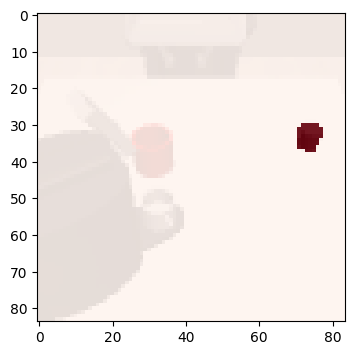

In [6]:
mask = detections[0].mask

plt.figure(figsize=(4, 4))
plt.imshow(image_np[0])
plt.imshow(mask, cmap='Reds', alpha=0.9)  # overlay with transparency
plt.show()

In [7]:
fx = fy = 101.39696962
cx = cy = 42
width = height = 84
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
extrinsic = np.array([
    [ 0.        ,  0.70614784, -0.70806442,  0.5       ],
    [ 1.        ,  0.        ,  0.        ,  0.        ],
    [ 0.        , -0.70806442, -0.70614784,  1.35      ],
    [ 0.        ,  0.        ,  0.        ,  1.        ]
])

In [8]:
depth_frame = np.squeeze(depth_np[0])
rgb_frame = image_np[0]
depth_o3d = o3d.geometry.Image(depth_frame.astype(np.float32))
rgb_o3d = o3d.geometry.Image(rgb_frame.astype(np.uint8))

# scene reconstruction from the initial frame
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=rgb_o3d,
    depth=depth_o3d,
    depth_scale=1.0,
    depth_trunc=10,
    convert_rgb_to_intensity=False
)

# object to manipulate
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsic,
    np.linalg.inv(extrinsic) # camera -> world
)

In [9]:
traj_np[0]

array([[ 1.        ,  0.        ,  0.        , -0.12112109],
       [ 0.        ,  1.        ,  0.        ,  0.25924512],
       [ 0.        ,  0.        ,  1.        ,  0.823103  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
N_samples = 20
T = traj_np.shape[0]
pod_pc = np.asarray(pcd.points)[mask.flatten()]
idx = np.random.randint(0, high=pod_pc.shape[0], size=N_samples)
sampled_points = pod_pc[idx]

# x, y, z -> x, y, z, 1
sampled_points = np.append(sampled_points, np.ones((N_samples, 1)), axis=1)
flow_3d = np.zeros((T, N_samples, 4))
flow_3d[0] = sampled_points

sampled_points_centered = np.linalg.inv(traj_np[0]) @ sampled_points.T

for i in range(1, T):
    flow_3d[i] = (traj_np[i] @ sampled_points_centered).T

In [30]:
from scipy.interpolate import interp1d

arr = flow_3d
old_indices = np.linspace(0, 1, arr.shape[0])  # 221 points between 0 and 1

# Create new indices for the desired array.
new_indices = np.linspace(0, 1, 100)             # 200 points between 0 and 1

# Build an interpolation function along the first axis.
interp_func = interp1d(old_indices, arr, axis=0, kind='linear')

# Evaluate the interpolation function at the new indices.
new_arr = interp_func(new_indices)
print(new_arr.shape)  # Should output (200, 30, 
flow_3d = new_arr

(100, 20, 4)


In [37]:
np.allclose(arr[-1], new_arr[-1])

True

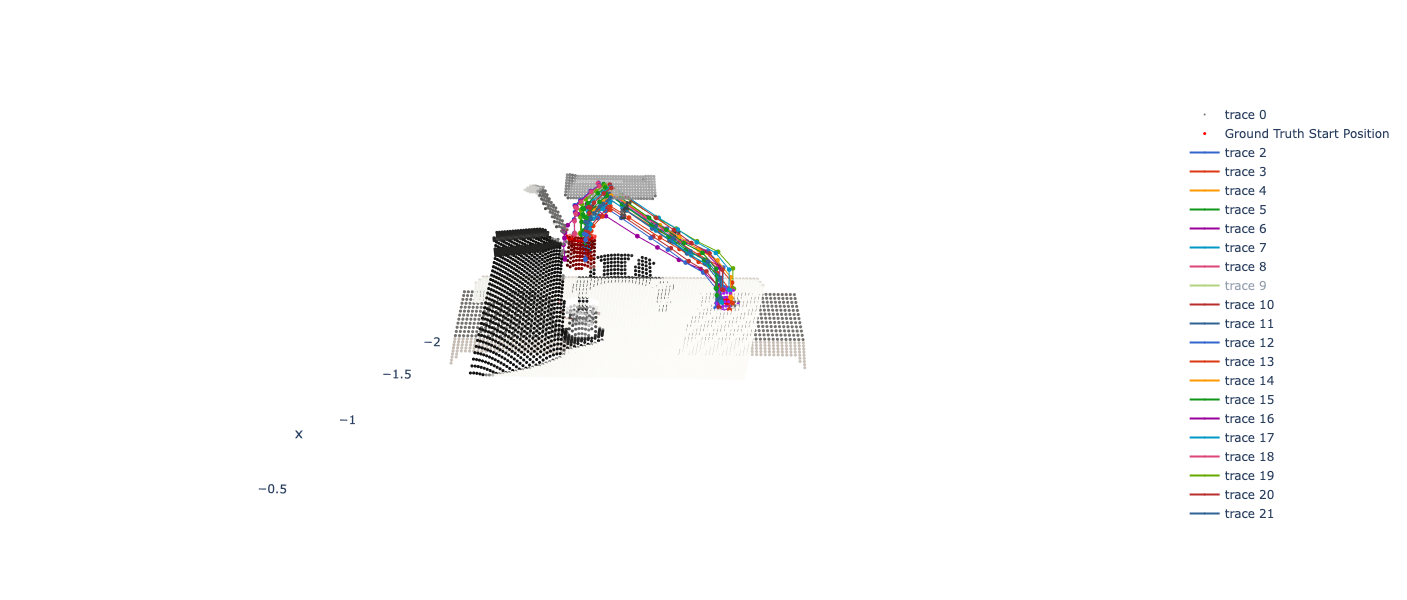

In [29]:
import plotly.graph_objects as go
import plotly.express as px

points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

colors_255 = (colors * 255).astype(np.uint8)
hex_colors = [f"rgb({r},{g},{b})" for r, g, b in colors_255]

# color detected points purple
for i, c in enumerate(hex_colors):
    if mask.flatten()[i]:
        hex_colors[i] = "rgb(160,32,240)"

fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=hex_colors
    )
)])

test_point = traj_np[0][0:3,-1]  # ground truth position of the coffee cup

fig.add_trace(go.Scatter3d(
    x=[test_point[0]],
    y=[test_point[1]],
    z=[test_point[2]],
    mode='markers',
    marker=dict(
        size=3,
        color="rgb(255,0,0)"
    ),
    name="Ground Truth Start Position"
))

colors = list(px.colors.qualitative.G10) * 5

# Add each trajectory as a separate trace.
for i in range(N_samples):
    fig.add_trace(go.Scatter3d(
        x=flow_3d[::5,i,0],
        y=flow_3d[::5,i,1],
        z=flow_3d[::5,i,2],
        mode='markers+lines',
        marker=dict(size=1.5, color=colors[i]),
        line=dict(color=colors[i], width=2),
    ))

fig.update_layout(
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    scene=dict(
        bgcolor='white',
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    )
)
fig.show()

In [13]:
arr = rearrange(flow_3d[::5, :, :3], "T N D -> T (N D)")
# arr = (arr[:-1] - arr[1:])
# arr_scaled = (arr + np.abs(np.min(arr))) / (np.max(arr) - np.min(arr))

In [14]:
arr

array([[-0.1220998 ,  0.26584388,  0.85105371, ..., -0.1220998 ,
         0.26584388,  0.85105371],
       [-0.122055  ,  0.26587126,  0.85063697, ..., -0.122055  ,
         0.26587126,  0.85063697],
       [-0.1220334 ,  0.26584574,  0.85065485, ..., -0.1220334 ,
         0.26584574,  0.85065485],
       ...,
       [ 0.08297543, -0.05940318,  1.01087075, ...,  0.08297543,
        -0.05940318,  1.01087075],
       [ 0.08305637, -0.05924374,  1.0108499 , ...,  0.08305637,
        -0.05924374,  1.0108499 ],
       [ 0.08294346, -0.05915733,  1.01078596, ...,  0.08294346,
        -0.05915733,  1.01078596]])

In [15]:
flow_3d.shape

(221, 20, 4)